# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Assignment: RNN text generation with your favorite book


## 1. Dataset
- Download your favorite book from https://www.gutenberg.org/
- Combine all sonnets into a single text source.  
- Split into training (80%) and validation (20%).  

In [19]:
import requests

filename = 'book.txt'
url = 'https://www.gutenberg.org/cache/epub/75898/pg75898.txt'
res = requests.get(url, allow_redirects=True)

with open(file=filename,mode='w', encoding='utf-8') as f:
    f.write(res.text)

In [20]:
import re

with open(file=filename,mode='r', encoding='utf-8') as f:
    text = f.read()


pattern = re.compile(
    r"^[IVXLCDM]+\.\s*\n"
    r"(.*?)"
    r"(?=^[IVXLCDM]+\.\s*\n|\Z)",
    flags=re.MULTILINE | re.DOTALL
)

sonnets = pattern.findall(text)

with open("all_sonnets.txt", "w", encoding="utf-8") as out:
    for s in sonnets:
        out.write(s.strip() + "\n\n")

print(f"Number of sonnets: {len(sonnets)}")

Number of sonnets: 16


In [21]:
text = text.lower() # lowercase

import string
translator = str.maketrans('', '', string.punctuation)

# Remove punctuation
text = text.translate(translator)

text = text.split() # convert to words array

total_len = len(text) # total number of words
total_len

47249

In [22]:
train_len = int(total_len * 0.8)

train_text = text[:train_len]
test_text = text[train_len:]
print(f"Train length: {len(train_text)}")
print(f"Validation length: {len(test_text)}")

Train length: 37799
Validation length: 9450


## 2. Preprocessing
- Convert text to lowercase.  
- Remove punctuation (except basic sentence delimiters).  
- Tokenize by words or characters (your choice).  
- Build a vocabulary (map each unique word to an integer ID).

In [23]:
# tokenization has been done by words as text, train_text, and test_text are now words arrays.
# Also, they have already been converted to lower case and punctuations have been removed
from collections import Counter

counts = Counter(text)

vocab_tokens = [w for w, c in counts.items() if c >= 2]
vocab_tokens = sorted(vocab_tokens)

vocabulary = {w: i+1 for i, w in enumerate(vocab_tokens)}
vocabulary['<unk>'] = 0
vocab_size = len(vocabulary)

# for word in text:
#   if word not in vocabulary:
#     vocabulary[word] = id
#     id += 1

# vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2804


In [24]:
# Now, we will use our map to convert words to tokens
text_as_ids = [vocabulary.get(word, 0) for word in text]

sequence_length = 15
X = []
y = []

for i in range(len(text_as_ids) - sequence_length):
  X.append(text_as_ids[i:i+sequence_length])
  y.append(text_as_ids[i+sequence_length])

import numpy as np

X = np.array(X)
y = np.array(y)

print(X[:10])
print(y[:10])

[[   0 1826 1079  720 1619 1269   86 1151 1647 2435  720 1261  930 2415
  2578]
 [1826 1079  720 1619 1269   86 1151 1647 2435  720 1261  930 2415 2578
  1619]
 [1079  720 1619 1269   86 1151 1647 2435  720 1261  930 2415 2578 1619
   104]
 [ 720 1619 1269   86 1151 1647 2435  720 1261  930 2415 2578 1619  104
   106]
 [1619 1269   86 1151 1647 2435  720 1261  930 2415 2578 1619  104  106
  1225]
 [1269   86 1151 1647 2435  720 1261  930 2415 2578 1619  104  106 1225
  2415]
 [  86 1151 1647 2435  720 1261  930 2415 2578 1619  104  106 1225 2415
  2559]
 [1151 1647 2435  720 1261  930 2415 2578 1619  104  106 1225 2415 2559
  2280]
 [1647 2435  720 1261  930 2415 2578 1619  104  106 1225 2415 2559 2280
    86]
 [2435  720 1261  930 2415 2578 1619  104  106 1225 2415 2559 2280   86
  1530]]
[1619  104  106 1225 2415 2559 2280   86 1530 1650]


## 3. Embedding Layer in Keras
Below is a minimal example of defining an `Embedding` layer:
```python
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length
)
```
- This layer transforms integer-encoded sequences (word IDs) into dense vector embeddings.

- Feed these embeddings into your LSTM or GRU OR 1D CNN layer.

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

batch_size = 64
epochs = 5
buffer_size = 10000

embedding_dim = 128

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size, drop_remainder=True)


embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = 128,
    input_length = sequence_length
)

es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## 4. Model
- Implement an LSTM or GRU or 1D CNN-based language model with:
  - **The Embedding layer** as input.
  - At least **one recurrent layer** (e.g., `LSTM(256)` or `GRU(256)` or your custom 1D CNN).
  - A **Dense** output layer with **softmax** activation for word prediction.
- Train for about **5–10 epochs** so it can finish in approximately **2 hours** on a standard machine.


In [26]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(256, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout = 0.2, recurrent_dropout=0.2))
model.add(Dense(units = vocab_size, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics = ['accuracy'])
model.summary()

import math

batch_size = 64
epochs = 5

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
591/591 ━━━━━━━━━━━━━━━━━━━━ 183s 297ms/step - accuracy: 0.0629 - loss: 6.3903 - val_accuracy: 0.0834 - val_loss: 6.0196
Epoch 2/5
591/591 ━━━━━━━━━━━━━━━━━━━━ 176s 298ms/step - accuracy: 0.0904 - loss: 5.8460 - val_accuracy: 0.1030 - val_loss: 5.8466
Epoch 3/5
591/591 ━━━━━━━━━━━━━━━━━━━━ 176s 298ms/step - accuracy: 0.1039 - loss: 5.6207 - val_accuracy: 0.1084 - val_loss: 5.7342
Epoch 4/5
591/591 ━━━━━━━━━━━━━━━━━━━━ 211s 314ms/step - accuracy: 0.1096 - loss: 5.5223 - val_accuracy: 0.1100 - val_loss: 5.6885
Epoch 5/5
591/591 ━━━━━━━━━━━━━━━━━━━━ 193s 298ms/step - accuracy: 0.1149 - loss: 5.4029 - val_accuracy: 0.1093 - val_loss: 5.6695
Restoring model weights from the end of the best epoch: 5.


## 5. Training & Evaluation
- **Monitor** the loss on both training and validation sets.
- **Perplexity**: a common metric for language models.
  - It is the exponent of the average negative log-likelihood.
  - If your model outputs cross-entropy loss `H`, then `perplexity = e^H`.
  - Try to keep the validation perplexity **under 50** if possible.

Final train perplexity:   221.96
Final val perplexity: 289.88


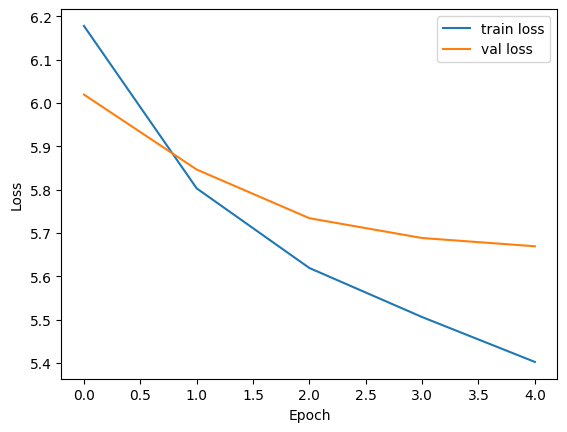

In [27]:
train_loss = history.history['loss'][-1]
val_loss   = history.history['val_loss'][-1]

train_perplexity = math.exp(train_loss)
val_perplexity   = math.exp(val_loss)

print(f"Final train perplexity:   {train_perplexity:.2f}")
print(f"Final val perplexity: {val_perplexity:.2f}")

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6. Generation Criteria
- After training, generate **two distinct text samples**, each at least **50 tokens**.
- Use **different seed phrases** (e.g., “love is” vs. “time will”).

In [30]:
id_to_word = {idx: word for word, idx in vocabulary.items()}

def generate_text(model, seed_text, gen_length=50, temperature=1.0):
    seed_ids = [vocabulary.get(w, vocabulary.get('<unk>', 0)) for w in seed_text.lower().split()]
    generated_ids = seed_ids.copy()

    for _ in range(gen_length):
        input_ids = generated_ids[-sequence_length:]
        if len(input_ids) < sequence_length:
            input_ids = [0] * (sequence_length - len(input_ids)) + input_ids

        input_array = np.array(input_ids)[None, :]
        # predicting next-token probabilities
        preds = model.predict(input_array, verbose=0)[0]
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        next_id = np.random.choice(range(vocab_size), p=preds)
        generated_ids.append(next_id)

    # back to words
    generated_words = [id_to_word.get(i, '<unk>') for i in generated_ids]
    return ' '.join(generated_words)

sample1 = generate_text(model, seed_text="love is",   gen_length=50, temperature=0.8)
sample2 = generate_text(model, seed_text="time will", gen_length=50, temperature=0.8)

print(sample1)
print(sample2)

love is the attention under his <unk> was that the treby who were be went he end him and a hottentot divided at the latin mind for his book and with with his <unk> he was not was get it was able them this danger to he confirmed out to but the
time will beside to i copied the gutenberg™ <unk> <unk> <unk> on no <unk> to was a own dutch were a friend had had not was with on the felt was not be far had found and was cat her <unk> if his wall in the great <unk> of the life between
